In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, utils
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import os

In [2]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Hyperparameters
TIMESTEPS = 1000
BATCH_SIZE = 128
EPOCHS = 10  # Increased for better results
LEARNING_RATE = 1e-4
IMG_SIZE = 28
CHANNELS = 1

# Define sinusoidal embedding
def sinusoidal_embedding(timesteps, dim):
    half_dim = dim // 2
    emb = np.log(10000) / (half_dim - 1)
    emb = torch.exp(torch.arange(half_dim, dtype=torch.float32, device=timesteps.device) * -emb)
    emb = timesteps.float()[:, None] * emb[None, :]
    emb = torch.cat([torch.sin(emb), torch.cos(emb)], dim=1)
    if dim % 2 == 1:
        emb = F.pad(emb, (0, 1))
    return emb

Using device: cuda


In [3]:

# UNet remains the same
class MNIST_UNet(nn.Module):
    def __init__(self, in_channels=1, out_channels=1, time_dim=256):
        super().__init__()
        
        self.time_mlp = nn.Sequential(
            nn.Linear(time_dim, time_dim),
            nn.SiLU(),
            nn.Linear(time_dim, time_dim)
        )
        
        self.enc1 = nn.Sequential(
            nn.Conv2d(in_channels, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
        )
        
        self.enc2 = nn.Sequential(
            nn.Conv2d(64, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
        )
        
        self.enc3 = nn.Sequential(
            nn.Conv2d(128, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
        )
        
        self.bottleneck = nn.Sequential(
            nn.Conv2d(256, 512, 3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 512, 3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
        )
        
        self.dec3 = nn.Sequential(
            nn.Conv2d(512 + 256, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
        )
        
        self.dec2 = nn.Sequential(
            nn.Conv2d(256 + 128, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
        )
        
        self.dec1 = nn.Sequential(
            nn.Conv2d(128 + 64, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
        )
        
        self.final_conv = nn.Conv2d(64, out_channels, 1)
        
        self.time_proj1 = nn.Linear(time_dim, 64)
        self.time_proj2 = nn.Linear(time_dim, 128)
        self.time_proj3 = nn.Linear(time_dim, 256)
        self.time_proj_bottleneck = nn.Linear(time_dim, 512)
        
        self.pool = nn.MaxPool2d(2)
        self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        
    def forward(self, x, t):
        t_emb = sinusoidal_embedding(t, 256)
        t_emb = self.time_mlp(t_emb)
        
        x1 = self.enc1(x)
        t_emb1 = self.time_proj1(t_emb)[:, :, None, None].expand(-1, -1, x1.shape[2], x1.shape[3])
        x1 = x1 + t_emb1
        
        x2 = self.enc2(self.pool(x1))
        t_emb2 = self.time_proj2(t_emb)[:, :, None, None].expand(-1, -1, x2.shape[2], x2.shape[3])
        x2 = x2 + t_emb2
        
        x3 = self.enc3(self.pool(x2))
        t_emb3 = self.time_proj3(t_emb)[:, :, None, None].expand(-1, -1, x3.shape[2], x3.shape[3])
        x3 = x3 + t_emb3
        
        x4 = self.bottleneck(self.pool(x3))
        t_emb_b = self.time_proj_bottleneck(t_emb)[:, :, None, None].expand(-1, -1, x4.shape[2], x4.shape[3])
        x4 = x4 + t_emb_b
        
        x = self.up(x4)
        if x.shape[2:] != x3.shape[2:]:
            x = F.interpolate(x, size=x3.shape[2:], mode='bilinear', align_corners=True)
        x = torch.cat([x, x3], dim=1)
        x = self.dec3(x)
        
        x = self.up(x)
        if x.shape[2:] != x2.shape[2:]:
            x = F.interpolate(x, size=x2.shape[2:], mode='bilinear', align_corners=True)
        x = torch.cat([x, x2], dim=1)
        x = self.dec2(x)
        
        x = self.up(x)
        if x.shape[2:] != x1.shape[2:]:
            x = F.interpolate(x, size=x1.shape[2:], mode='bilinear', align_corners=True)
        x = torch.cat([x, x1], dim=1)
        x = self.dec1(x)
        
        return self.final_conv(x)

In [4]:
# ============================================================================
# CORRECT IMPLEMENTATION: Predict x0 directly
# ============================================================================
class DDPM_predict_x0:
    """
    CORRECT: DDPM that predicts x0 (clean image) directly
    This works because x0 and ε are linearly related!
    """
    def __init__(self, model, timesteps=1000, beta_start=1e-4, beta_end=0.02, device=device):
        self.model = model
        self.timesteps = timesteps
        self.device = device
        
        # Create linear variance schedule
        self.betas = torch.linspace(beta_start, beta_end, timesteps, device=device)
        self.alphas = 1. - self.betas
        self.alpha_bars = torch.cumprod(self.alphas, dim=0)
        
    def add_noise(self, x0, t):
        """Forward diffusion process: q(x_t | x_0)"""
        sqrt_alpha_bar = torch.sqrt(self.alpha_bars[t])[:, None, None, None]
        sqrt_one_minus_alpha_bar = torch.sqrt(1. - self.alpha_bars[t])[:, None, None, None]
        
        epsilon = torch.randn_like(x0)
        xt = sqrt_alpha_bar * x0 + sqrt_one_minus_alpha_bar * epsilon
        return xt, epsilon
    
    def sample_timesteps(self, n):
        """Sample random timesteps for training"""
        return torch.randint(0, self.timesteps, (n,), device=self.device).long()
    
    @torch.no_grad()
    def sample(self, n_samples=16, verbose=False):
        """CORRECT DDPM sampling using x0 prediction"""
        self.model.eval()
        
        # Start from pure noise
        x = torch.randn((n_samples, CHANNELS, IMG_SIZE, IMG_SIZE), device=self.device)
        
        intermediates = []
        
        iterator = reversed(range(self.timesteps))
        if verbose:
            iterator = tqdm(iterator, desc='Sampling (Predict x0)', total=self.timesteps)
        
        for i in iterator:
            t = torch.full((n_samples,), i, device=self.device, dtype=torch.long)
            
            # Predict x0 directly (clean image)
            pred_x0 = self.model(x, t)
            
            # Calculate coefficients
            alpha = self.alphas[t][:, None, None, None]
            alpha_bar = self.alpha_bars[t][:, None, None, None]
            beta = self.betas[t][:, None, None, None]
            
            # Convert x0 prediction to noise prediction
            # From forward process: x_t = √(ᾱ_t)x_0 + √(1-ᾱ_t)ε
            # So: ε = (x_t - √(ᾱ_t)x_0) / √(1-ᾱ_t)
            pred_noise = (x - torch.sqrt(alpha_bar) * pred_x0) / torch.sqrt(1 - alpha_bar)
            
            if i > 0:
                noise = torch.randn_like(x)
            else:
                noise = torch.zeros_like(x)
            
            # CORRECT DDPM update (Algorithm 2 from paper)
            x = (1 / torch.sqrt(alpha)) * (
                x - ((1 - alpha) / torch.sqrt(1 - alpha_bar)) * pred_noise
            ) + torch.sqrt(beta) * noise
            
            if i % 100 == 0 or i < 10:
                intermediates.append(x.detach().cpu())
        
        self.model.train()
        return x, intermediates
    
    def compute_loss(self, x0):
        """Direct x0 prediction loss"""
        t = self.sample_timesteps(x0.shape[0])
        xt, _ = self.add_noise(x0, t)
        
        # Model predicts x0 (clean image) directly
        pred_x0 = self.model(xt, t)
        
        # Loss: how well we predict the original clean image
        return F.mse_loss(pred_x0, x0)

In [5]:
# ============================================================================
# Training and visualization
# ============================================================================
def get_dataloaders():
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])
    
    train_dataset = datasets.MNIST(
        root='./data',
        train=True,
        download=True,
        transform=transform
    )
    
    train_loader = DataLoader(
        train_dataset,
        batch_size=BATCH_SIZE,
        shuffle=True,
        num_workers=2,
        pin_memory=True
    )
    
    return train_loader

def display_samples(samples, title="Generated Samples", nrow=4, save_path=None):
    """Display samples in a grid"""
    samples = samples.cpu()
    samples = (samples + 1) / 2  # Denormalize from [-1, 1] to [0, 1]
    grid = utils.make_grid(samples, nrow=nrow, padding=2, normalize=False)
    
    plt.figure(figsize=(10, 10))
    plt.imshow(grid.permute(1, 2, 0).squeeze(), cmap='gray')
    plt.axis('off')
    plt.title(title, fontsize=16, pad=20)
    
    if save_path:
        plt.savefig(save_path, bbox_inches='tight', pad_inches=0.1)
    
    plt.show()

def train(model, diffusion, train_loader, epochs=EPOCHS, lr=LEARNING_RATE):
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)
    
    model.train()
    losses = []
    
    for epoch in range(epochs):
        epoch_loss = 0
        pbar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{epochs}')
        
        for batch_idx, (data, _) in enumerate(pbar):
            data = data.to(device)
            
            # Loss: predict clean image x0
            loss = diffusion.compute_loss(data)
            
            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            
            epoch_loss += loss.item()
            pbar.set_postfix({'loss': loss.item()})
        
        scheduler.step()
        avg_loss = epoch_loss / len(train_loader)
        losses.append(avg_loss)
        print(f'Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}')
        
        # Generate and display samples after each epoch
        print(f"Generating samples after epoch {epoch+1}...")
        with torch.no_grad():
            samples, _ = diffusion.sample(n_samples=16, verbose=False)
            display_samples(samples, 
                          title=f'Epoch {epoch+1} - Predicting x0',
                          save_path=f'samples_epoch_{epoch+1}.png')
    
    return losses

DDPM PREDICTING x0 (CLEAN IMAGE) DIRECTLY
Model parameters: 8,165,697
Training batches: 469

Real MNIST samples:


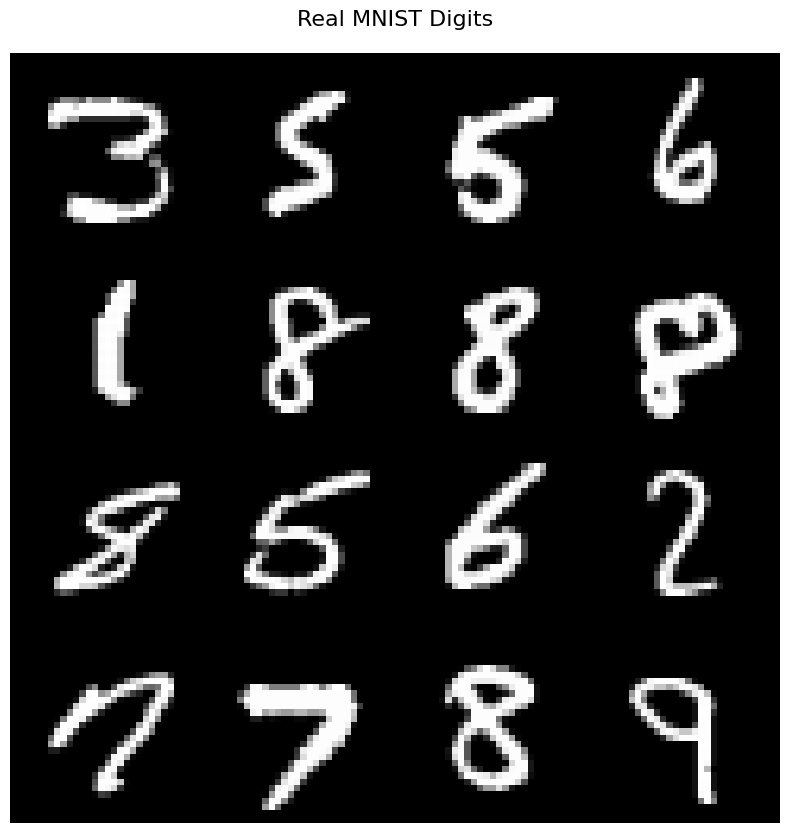


TRAINING


Epoch 1/10: 100%|██████████| 469/469 [00:58<00:00,  8.04it/s, loss=0.15] 


Epoch 1/10, Loss: 0.1716
Generating samples after epoch 1...


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


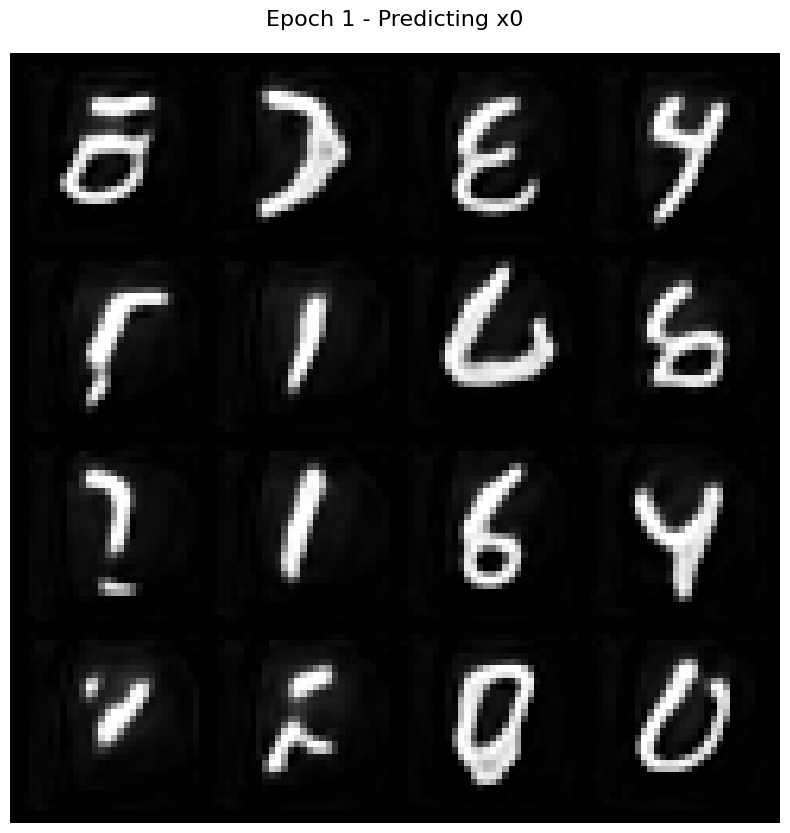

Epoch 2/10: 100%|██████████| 469/469 [00:57<00:00,  8.09it/s, loss=0.15] 


Epoch 2/10, Loss: 0.1522
Generating samples after epoch 2...


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


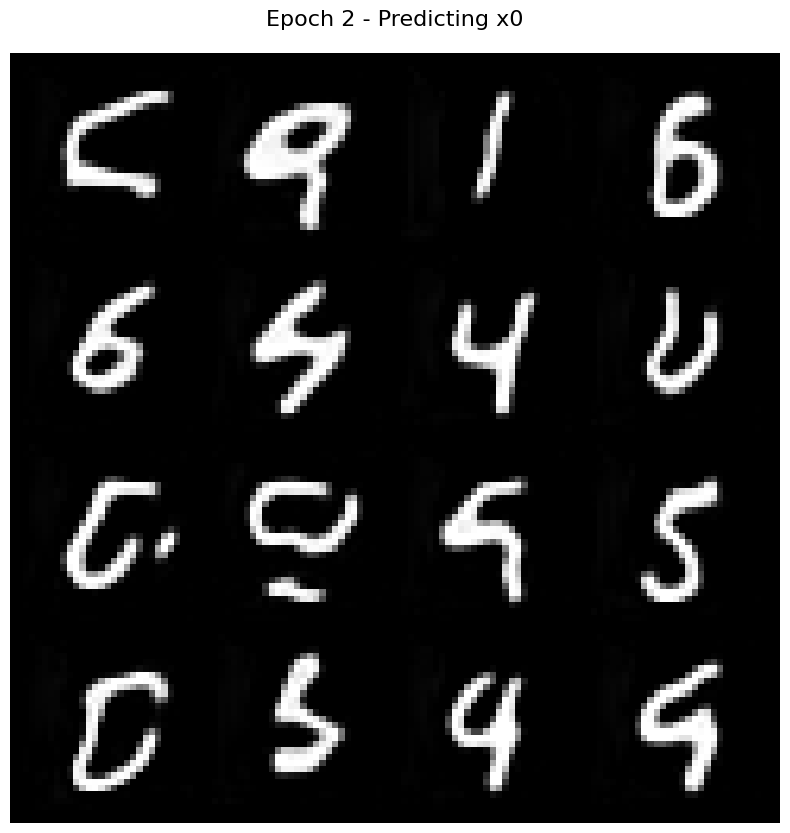

Epoch 3/10: 100%|██████████| 469/469 [00:57<00:00,  8.09it/s, loss=0.178]


Epoch 3/10, Loss: 0.1515
Generating samples after epoch 3...


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


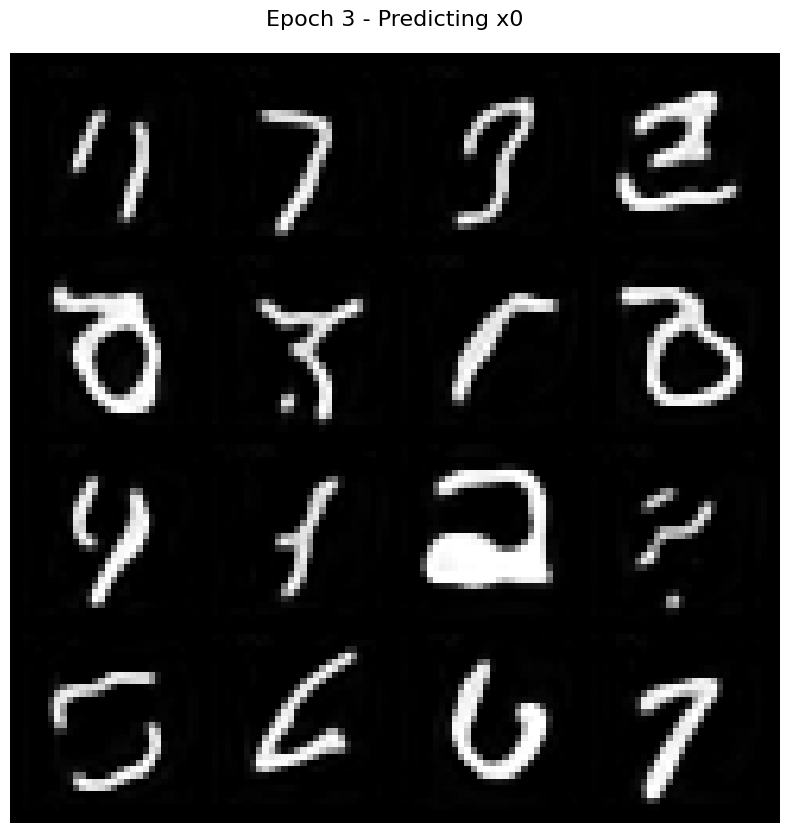

Epoch 4/10: 100%|██████████| 469/469 [00:58<00:00,  8.08it/s, loss=0.167]


Epoch 4/10, Loss: 0.1505
Generating samples after epoch 4...


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


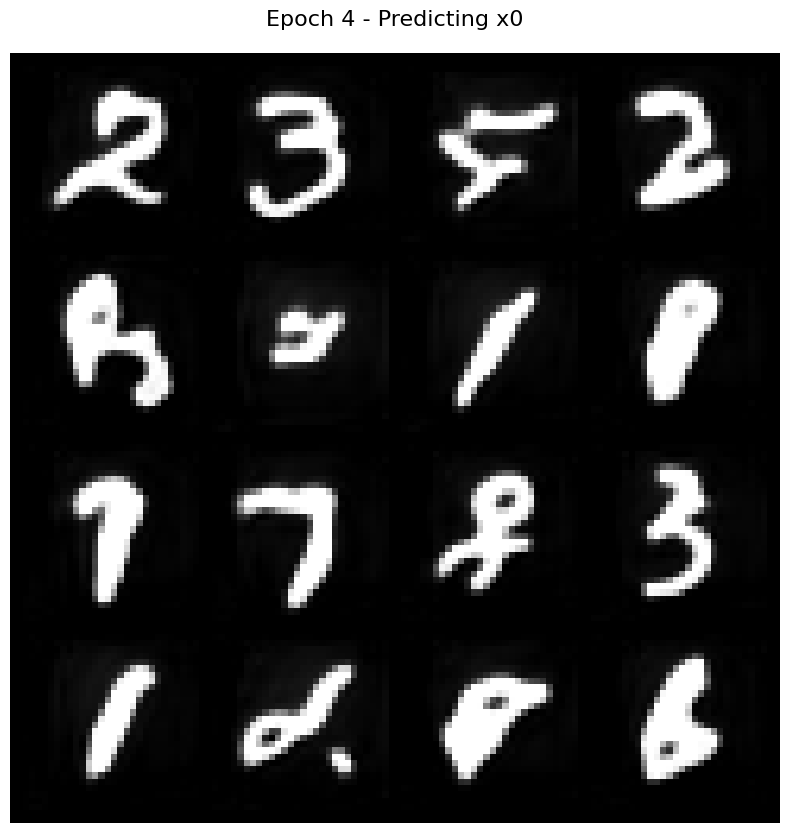

Epoch 5/10: 100%|██████████| 469/469 [00:57<00:00,  8.10it/s, loss=0.153]


Epoch 5/10, Loss: 0.1490
Generating samples after epoch 5...


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


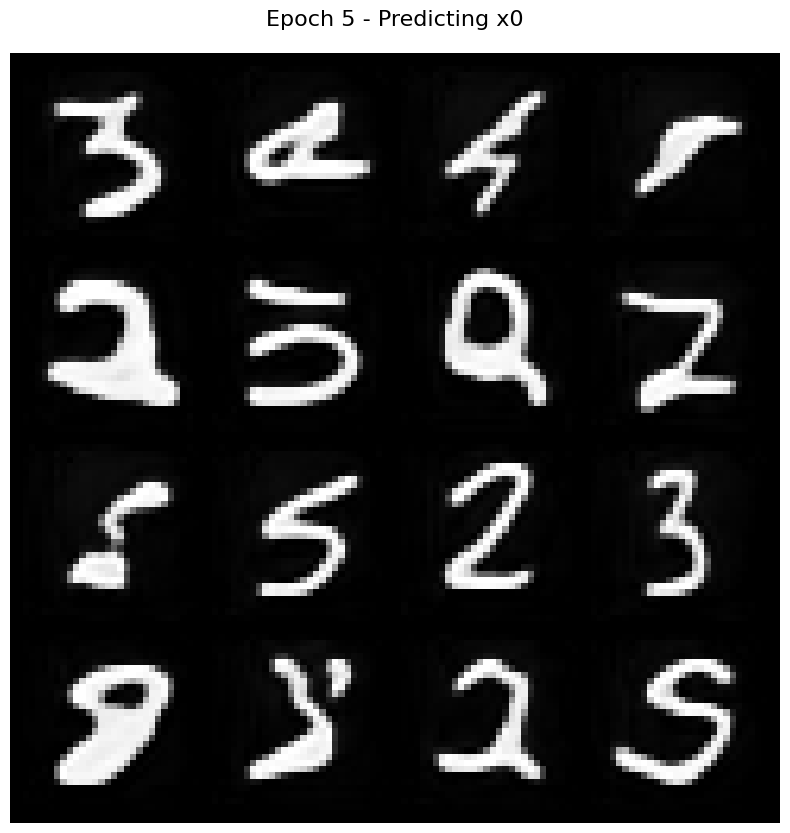

Epoch 6/10: 100%|██████████| 469/469 [00:57<00:00,  8.09it/s, loss=0.142]


Epoch 6/10, Loss: 0.1487
Generating samples after epoch 6...


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


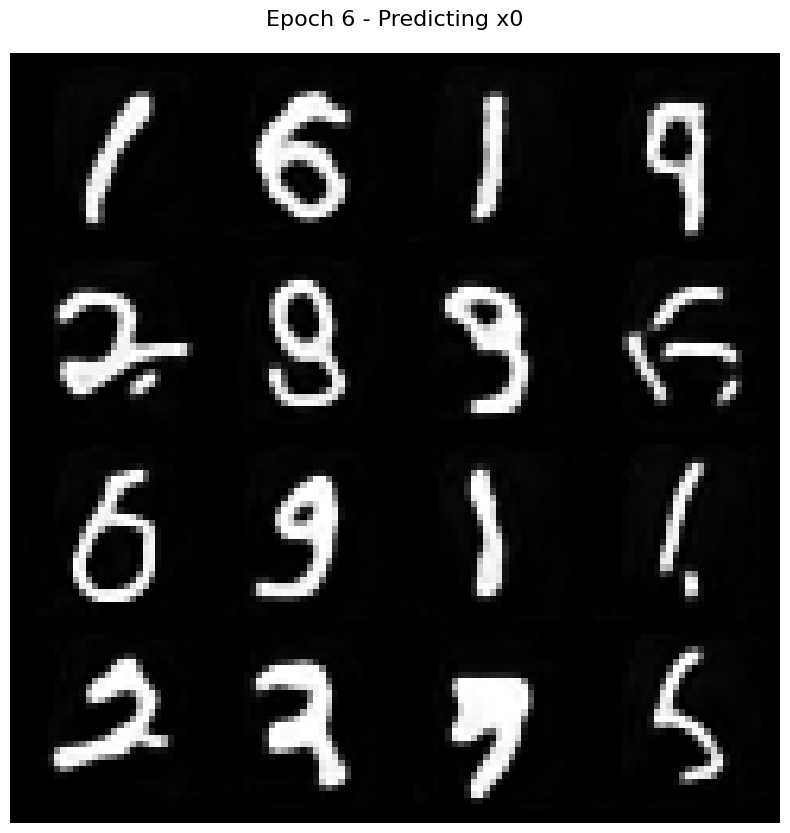

Epoch 7/10: 100%|██████████| 469/469 [00:57<00:00,  8.09it/s, loss=0.142]


Epoch 7/10, Loss: 0.1476
Generating samples after epoch 7...


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


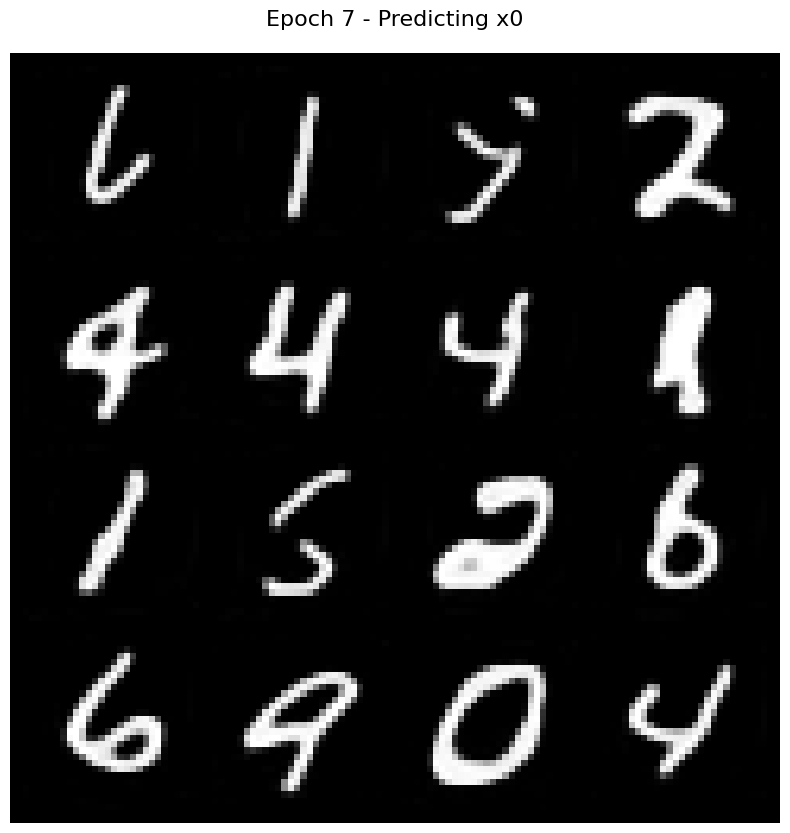

Epoch 8/10: 100%|██████████| 469/469 [00:57<00:00,  8.09it/s, loss=0.146]


Epoch 8/10, Loss: 0.1467
Generating samples after epoch 8...


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


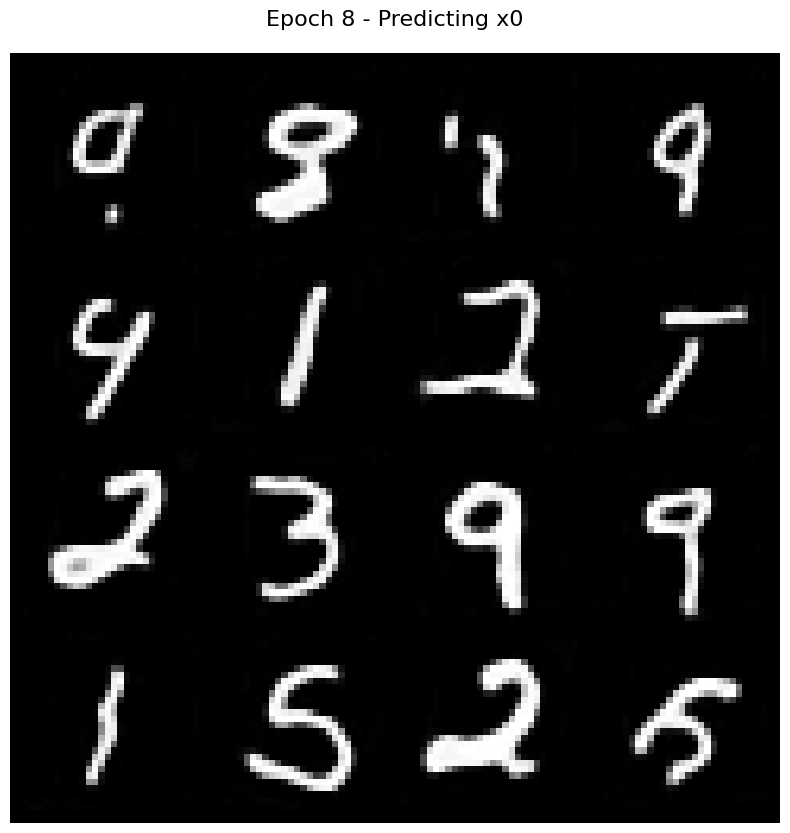

Epoch 9/10: 100%|██████████| 469/469 [00:57<00:00,  8.09it/s, loss=0.149]


Epoch 9/10, Loss: 0.1467
Generating samples after epoch 9...


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


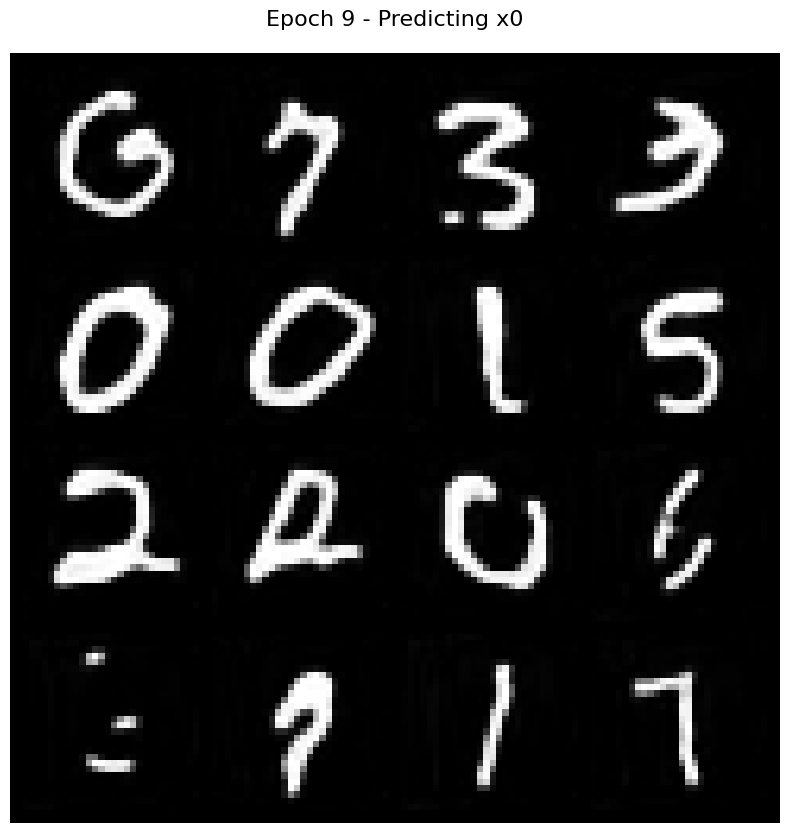

Epoch 10/10: 100%|██████████| 469/469 [00:57<00:00,  8.09it/s, loss=0.169]


Epoch 10/10, Loss: 0.1469
Generating samples after epoch 10...


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


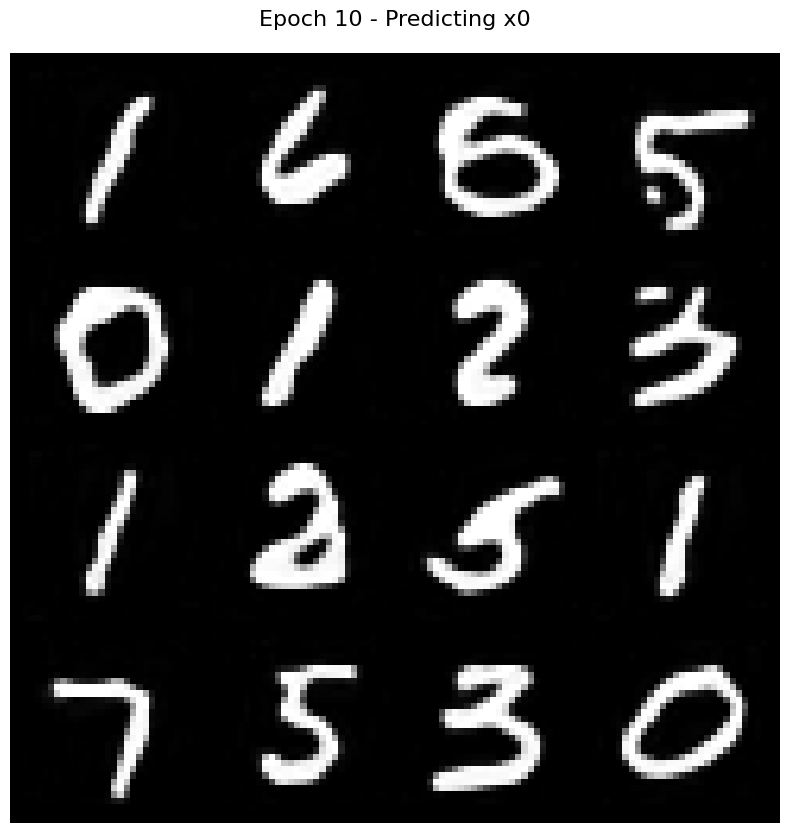

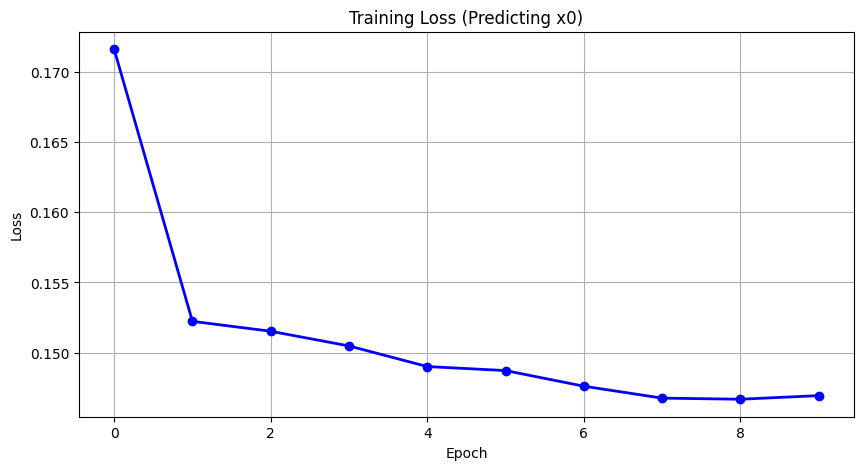


FINAL SAMPLES


Sampling (Predict x0): 100%|██████████| 1000/1000 [00:08<00:00, 122.73it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


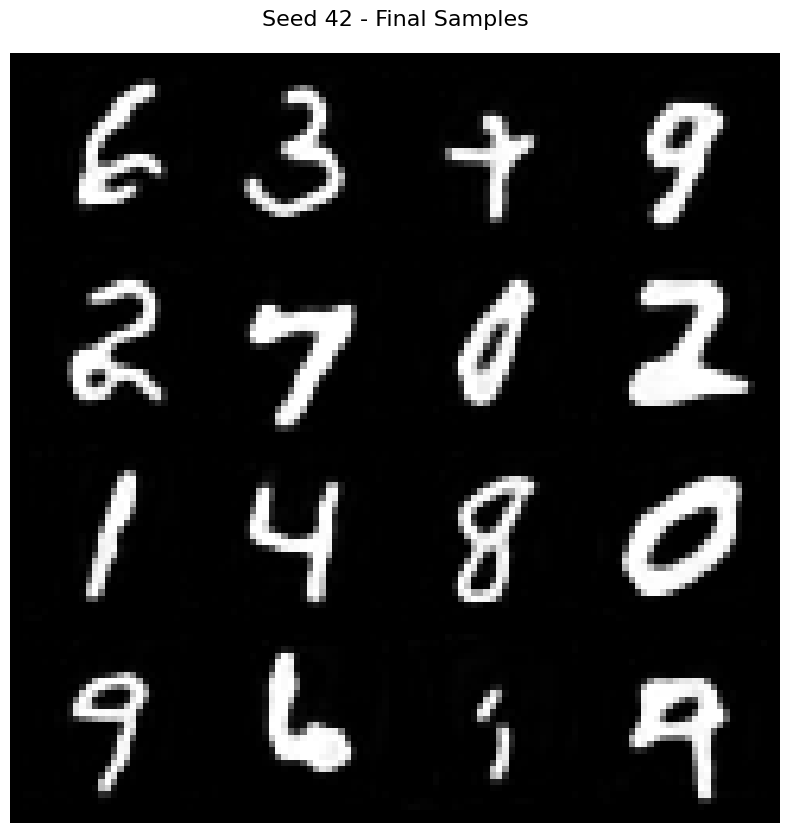

Sampling (Predict x0): 100%|██████████| 1000/1000 [00:08<00:00, 122.74it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


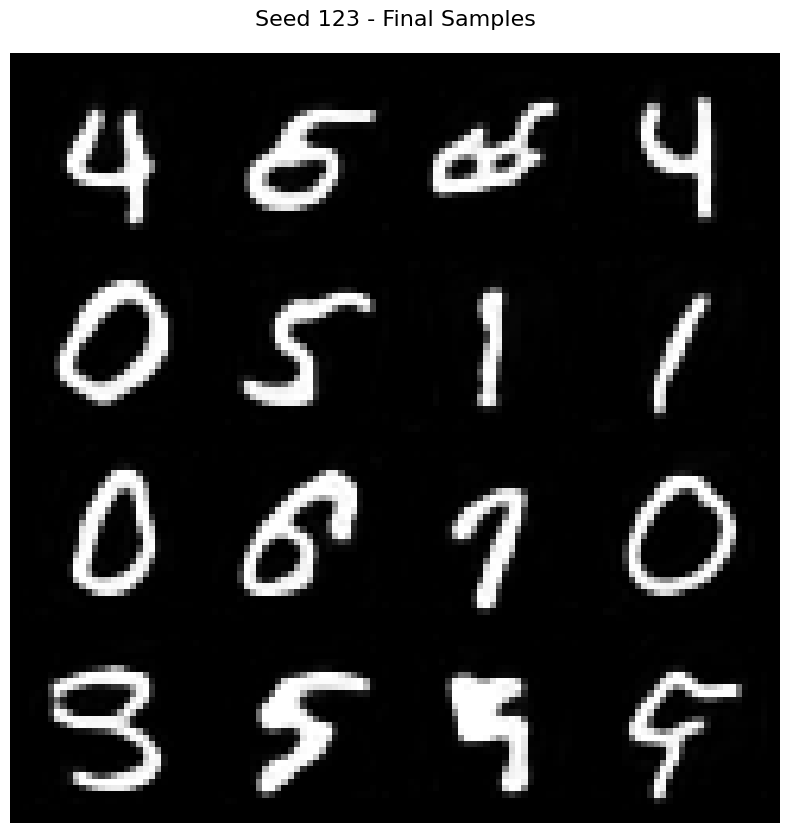


WHY THIS WORKS

Forward process:
  x_t = √(ᾱ_t) * x_0 + √(1-ᾱ_t) * ε

Predicting x0 directly:
  • Model: f_θ(x_t, t) = x̂_0
  • Loss: L = ||x_0 - x̂_0||²

Sampling (convert to noise then use DDPM formula):
  1. Predict x̂_0 = f_θ(x_t, t)
  2. Convert to noise: ε̂ = (x_t - √(ᾱ_t)x̂_0) / √(1-ᾱ_t)
  3. DDPM update: x_{t-1} = 1/√α_t (x_t - (1-α_t)/√(1-ᾱ_t)ε̂) + √β_t z

Why this is equivalent to predicting ε:
  From forward process: ε = (x_t - √(ᾱ_t)x_0) / √(1-ᾱ_t)
  So: ε_θ(x_t, t) = (x_t - √(ᾱ_t)f_θ(x_t, t)) / √(1-ᾱ_t)
  They are LINEARLY RELATED!

Advantages of predicting x0:
  • More intuitive: Direct image reconstruction
  • Model output is interpretable (clean image)
  • Works just as well as predicting ε

Expected results:
  • Loss should decrease steadily
  • Generated samples should look like MNIST digits
  • Different seeds produce different but coherent digits


In [6]:
# Create directories
os.makedirs('samples', exist_ok=True)
os.makedirs('checkpoints', exist_ok=True)

print("="*60)
print("DDPM PREDICTING x0 (CLEAN IMAGE) DIRECTLY")
print("="*60)

# Initialize
model = MNIST_UNet(in_channels=CHANNELS, out_channels=CHANNELS).to(device)
diffusion = DDPM_predict_x0(model, timesteps=TIMESTEPS, device=device)

print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")

# Get data
train_loader = get_dataloaders()
print(f"Training batches: {len(train_loader)}")

# Show real samples
print("\nReal MNIST samples:")
real_samples = next(iter(train_loader))[0][:16].to(device)
display_samples(real_samples, title="Real MNIST Digits")

# Train
print("\n" + "="*60)
print("TRAINING")
print("="*60)
losses = train(model, diffusion, train_loader, epochs=EPOCHS)

# Plot loss
plt.figure(figsize=(10, 5))
plt.plot(losses, 'b-', linewidth=2, marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss (Predicting x0)')
plt.grid(True)
plt.savefig('training_loss.png', bbox_inches='tight')
plt.show()

# Final samples
print("\n" + "="*60)
print("FINAL SAMPLES")
print("="*60)

for seed in [42, 123]:
    torch.manual_seed(seed)
    with torch.no_grad():
        samples, intermediates = diffusion.sample(n_samples=16, verbose=True)
        display_samples(samples, title=f"Seed {seed} - Final Samples")

# Mathematical explanation
print("\n" + "="*60)
print("WHY THIS WORKS")
print("="*60)
print("\nForward process:")
print("  x_t = √(ᾱ_t) * x_0 + √(1-ᾱ_t) * ε")

print("\nPredicting x0 directly:")
print("  • Model: f_θ(x_t, t) = x̂_0")
print("  • Loss: L = ||x_0 - x̂_0||²")

print("\nSampling (convert to noise then use DDPM formula):")
print("  1. Predict x̂_0 = f_θ(x_t, t)")
print("  2. Convert to noise: ε̂ = (x_t - √(ᾱ_t)x̂_0) / √(1-ᾱ_t)")
print("  3. DDPM update: x_{t-1} = 1/√α_t (x_t - (1-α_t)/√(1-ᾱ_t)ε̂) + √β_t z")

print("\nWhy this is equivalent to predicting ε:")
print("  From forward process: ε = (x_t - √(ᾱ_t)x_0) / √(1-ᾱ_t)")
print("  So: ε_θ(x_t, t) = (x_t - √(ᾱ_t)f_θ(x_t, t)) / √(1-ᾱ_t)")
print("  They are LINEARLY RELATED!")

print("\nAdvantages of predicting x0:")
print("  • More intuitive: Direct image reconstruction")
print("  • Model output is interpretable (clean image)")
print("  • Works just as well as predicting ε")

print("\nExpected results:")
print("  • Loss should decrease steadily")
print("  • Generated samples should look like MNIST digits")
print("  • Different seeds produce different but coherent digits")
print("="*60)